# Movie Wars
## ~ Episode II – Attack of the Data  ~

First of all, we should set the notebook so that it outputs all results of each cell and not only the last one.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

And import all the python libraries needed for this data analysis.

In [2]:
import statistics
import pandas as pd
import seaborn as sns
from collections import Counter
import statsmodels

Next, let's define a **extension for the standard deviation** provided by the statistics package. The problem is that if we try to compute the standard deviation of a set with **less than two elements, we'll get an error**. 

Theorically, this error is correct, but in this case is appropiate to **define the standard deviation** of a set whose size is less than 2 **as 0**.

In [3]:
def std_mod(lst):
    return statistics.stdev(lst) if (len(lst) > 1) else 0

Last, we state where our data sources for the experiments will be.

In our case, they are 3 files about movies, users and ratings that our company **data engineer** has created for us containing a significant sample of our full production database of 26 million ratings, according to our criteria.

In [4]:
data_folder_path = 'data\\'

movies_file_path = data_folder_path + 'movies.csv'
users_file_path = data_folder_path + 'users.csv'
rating_file_path = data_folder_path + 'ratings.csv'

And load the data.

In [5]:
all_movies = pd.read_csv(movies_file_path, sep = ';', index_col = 'ID')
all_users = pd.read_csv(users_file_path, sep = ';', index_col = 'Id')
all_ratings = pd.read_csv(rating_file_path, sep = ',')

Now, we are ready to start with the data analysis.

## Basic analysis - Glance at the raw data

Let's describe what information do these datasets have and in what amounts

In [6]:
f"Movies dataset shape: {all_movies.shape}"
f"Users dataset shape: {all_users.shape}"
f"Ratings dataset shape: {all_ratings.shape}"

'Movies dataset shape: (3883, 2)'

'Users dataset shape: (6040, 3)'

'Ratings dataset shape: (500100, 4)'

#### Movies

In [7]:
all_movies.describe()

,Title,Genre
count,3883,3883
unique,3883,301
top,Hustler White (1996),Drama
freq,1,843


In [8]:
all_movies.head()

,Title,Genre
ID,,
1,Toy Story (1995),Animation|Children's|Comedy
2,Jumanji (1995),Adventure|Children's|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama
5,Father of the Bride Part II (1995),Comedy


This dataset contains information about the **title**, **year** and the **genres** asocciated with each movie;
but we will need to transform this information into useful columns.

#### Users

In [9]:
all_users.describe()

,Age,Occupation
count,6040.000000,6040.000000
mean,30.639238,8.146854
std,12.895962,6.329511
min,1.000000,0.000000
25%,25.000000,3.000000
50%,25.000000,7.000000
75%,35.000000,14.000000
max,56.000000,20.000000


In [10]:
all_users.head()

,Gender,Age,Occupation
Id,,,
1,F,1,10
2,M,56,16
3,M,25,15
4,M,45,7
5,M,25,20


This dataset has features related with the **gender**, **age** and **occupation** of the different users, but: 
- The **Age** column is not showing the real age of users but a mapping to different groups. 
- The **Occupation** column is filled with integers which are a mapping to their real occupations. 

We will need additional information on these two columns in order to preprocess them.

#### Ratings

In [11]:
all_ratings.describe()

,user,movie,rating
count,500100.000000,500100.000000,500100.000000
mean,4408.620518,1834.281214,3.602224
std,926.274862,1076.388887,1.114688
min,2783.000000,1.000000,1.000000
25%,3622.000000,1022.000000,3.000000
50%,4371.000000,1767.000000,4.000000
75%,5220.000000,2724.000000,4.000000
max,6040.000000,3952.000000,5.000000


In [12]:
all_ratings.head()

,user,movie,rating,id
0,2783,1253,5,2783_1253
1,2783,589,5,2783_589
2,2783,1270,4,2783_1270
3,2783,1274,4,2783_1274
4,2783,741,5,2783_741


Ratings are **integers** between 1 and 5, mostly centered around 3 and 4, that have asociated a unique pair of **user and movie ids**.

Our goal is to obtain an approximate rating for each missing user and movie pairs. So the first natural questions that arise are:
    
   - **Do we have ratings for all the movies?**
   - **Do we have ratings for all the users?**

In [13]:
movies_with_votes = list(all_ratings['movie'].unique())
users_with_votes = list(all_ratings['user'].unique())

f"Movies with ratings: {len(movies_with_votes)} ({round(len(movies_with_votes)/len(all_movies) * 100, 2)}%)"
f"Active users: {len(users_with_votes)} ({round(len(users_with_votes)/len(all_users) * 100, 2)}%)"

'Movies with ratings: 3551 (91.45%)'

'Active users: 3255 (53.89%)'

Almost all the movies has been rated, but **almost half** of the users have **not rated any movie** *(pasive users)*.

How we choose to handle this will have deep implications on the model selection stage.

## Deeper analysis - Understanding the data

Consulting with the domain experts *(or business analysts)* of area where the data comes from, we got back the following information about the **Occupation** and **Age**.

In [14]:
movie_genres = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy','Film-Noir','Horror',
 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

user_ages = {1: '0 - 17', 18: '18 - 24', 25: '25 - 34', 35: '35 - 44', 45: '45 - 49', 50: '50 - 55', 56: '56+'}

user_occupations = { 0:  "other", 1:  "academic/educator", 2:  "artist",  3:  "clerical/admin", 4:  "college/grad student",
                    5:  "customer service", 6:  "doctor/health care", 7:  "executive/managerial", 8:  "farmer", 9:  "homemaker",
                     10:  "K-12 student", 11:  "lawyer", 12:  "programmer", 13:  "retired", 14:  "sales/marketing", 15:  "scientist",
                     16:  "self-employed", 17:  "technician/engineer", 18:  "tradesman/craftsman", 19:  "unemployed", 20:  "writer"}

Let's take a deeper look at the different interesting columns.

#### Movies: Genre

We use **one-hot encoding**, adding a column per genre with 1 if the movie belongs to that genre or 0 otherwise, to create boolean features for the movies' genres.

In [15]:
for genre in movie_genres:
    all_movies[genre] = all_movies['Genre'].apply(lambda x: 1 if genre in x.split(sep = '|') else 0)

all_movies.describe()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000,3883.000000
mean,0.129539,0.072882,0.027041,0.064641,0.309039,0.054339,0.032707,0.412825,0.017512,0.011331,0.088334,0.029359,0.027298,0.121298,0.071079,0.126706,0.036827,0.017512
std,0.335839,0.259976,0.162224,0.245923,0.462157,0.226715,0.177891,0.492405,0.131187,0.105858,0.283816,0.168832,0.162973,0.326515,0.256990,0.332686,0.188362,0.131187
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Let's check it's distribution.

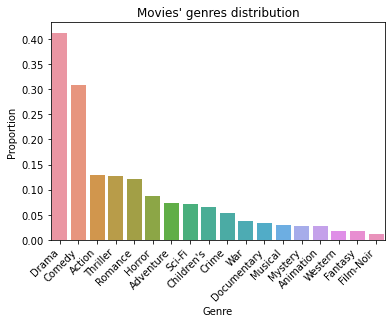

In [16]:
genre_distribution = pd.DataFrame({
    'Genre': movie_genres,
    'Proportion': list(map(lambda x : sum(all_movies[x]) / len(all_movies), movie_genres))
})

shorted_genres = genre_distribution.sort_values(by = 'Proportion', ascending = False)['Genre']

genre_barplot = sns.barplot(x = "Genre", y = "Proportion", data = genre_distribution, order = shorted_genres)
genre_barplot.set_xticklabels(genre_barplot.get_xticklabels(), rotation=45, horizontalalignment='right')
genre_barplot.set_title("Movies' genres distribution");

It seems that we have a 'dramatic' **umbalance** in the genres distribution, this would be true if if each movie was associated with a **single** genre; but it is not the case. For example: 

> The American President (1995) belongs to *Comedy*, *Drama* and *Romance* genres. 

This means that we will need to **normalize** the genre features taking in account the number of genres associated with each movie.

In [17]:
for genre in movie_genres:
    all_movies[genre + '_norm'] = all_movies['Genre'].apply(lambda x: 1/len(x.split(sep = '|')) if genre in x.split(sep = '|') else 0)
    all_movies['genre_num'] = all_movies['Genre'].apply(lambda x: len(x.split(sep = '|')))

And this is the resulting normalized genre distribution.

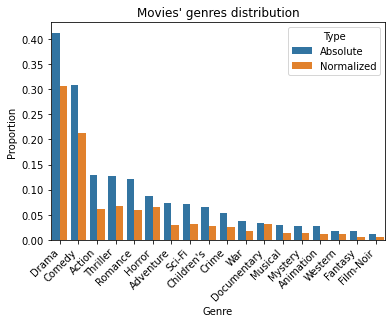

In [18]:
genre_distribution['Normalized'] = list(map(lambda x : sum(all_movies[x + '_norm']) / len(all_movies), movie_genres))
genre_distribution = genre_distribution.rename(columns={"Proportion": "Absolute"})
genre_distribution = pd.melt(genre_distribution, id_vars = "Genre", value_vars= ["Absolute", "Normalized"], var_name='Type', value_name='Proportion')

norm_genre_barplot = sns.barplot(x = "Genre", y = "Proportion", data = genre_distribution, hue = "Type", order = shorted_genres)
norm_genre_barplot.set_xticklabels(norm_genre_barplot.get_xticklabels(), rotation=45, horizontalalignment='right')
norm_genre_barplot.set_title("Movies' genres distribution");

Now comparing the distributions, we can see that the previous representation was not fitting the real situation. This second representation of the distribution is sightly different. For a better understanding of the movies genre, we would need more information about the movies like summary, tags and so on.

#### Movies: Year

The **year of release** for each movie can be easily extracted as a feature from the title.

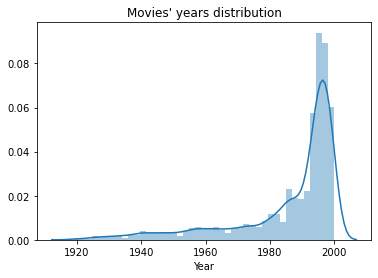

In [19]:
all_movies['Year'] = all_movies['Title'].apply(lambda x : int(x[-5:-1]))

year_barplot = sns.distplot(all_movies.Year)
year_barplot.set_title("Movies' years distribution");

We can see that almost all the movies were recorded between **1980** and **2000**.

#### Users: Age

Knowing the mapping to the users' age ranges, we can take a look at its distribution.

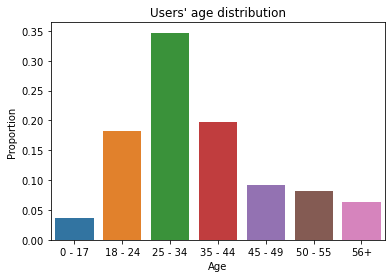

In [20]:
all_users['Age interval'] = all_users['Age'].map(lambda age_code: user_ages[age_code])

age_distribution = pd.DataFrame({
    'Age': list(user_ages.values()),
    'Count': [dict(all_users.Age.value_counts())[x] for x in user_ages.keys()],
    'Proportion': [dict(all_users.Age.value_counts())[x]/len(all_users) for x in user_ages.keys()]
})

age_barplot = sns.barplot(x = "Age", y = "Proportion", data = age_distribution)
age_barplot.set_title("Users' age distribution");

The users are centered around **20** to **40** years old, this can cause problems when maiking prediction for the  **old** and **young**. 

It is also worth mentioning that the intervals have not the same size and that the class mark are the minimun age, when the midpoint could be more representative.

#### Users: Occupation

Knowing the mapping to the users' occupations, we can take a look at its distribution.

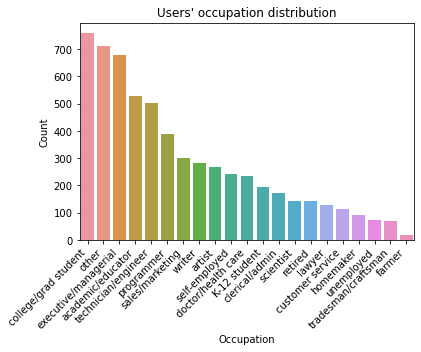

In [21]:
all_users['Occupation_decoded'] = all_users['Occupation'].map(lambda x: user_occupations[x])

occupation_distribution = pd.DataFrame({
    'Occupation': list(Counter(all_users.Occupation_decoded).keys()),
    'Count': list(Counter(all_users.Occupation_decoded).values())
})
occupations_order = occupation_distribution.sort_values(by = 'Count', ascending = False)['Occupation']

occupation_barplot = sns.barplot(x = "Occupation", y = "Count", data = occupation_distribution, order = occupations_order)
occupation_barplot.set_xticklabels(occupation_barplot.get_xticklabels(), rotation=45, horizontalalignment='right')
occupation_barplot.set_title("Users' occupation distribution");

It's quite **broad** having 20 different occupations, and very **unbalanced** with the 5 most common categories having more than half of the users.

This may not be very helpful, so we will have to redesign the occupation feature **by grouping** them to obtain a more balanced and reduced set.

#### Users: Gender

The gender of the users is also provided.

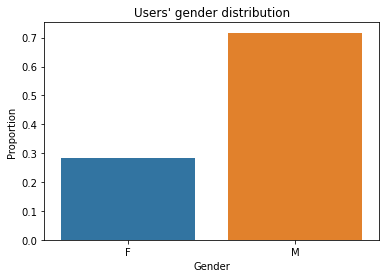

In [22]:
gender_distribution = pd.DataFrame({
    'Gender': list(Counter(all_users.Gender).keys()),
    'Count': list(Counter(all_users.Gender).values()),
    'Proportion': [Counter(all_users.Gender)[x]/len(all_users) for x in Counter(all_users.Gender).keys()]
})

gender_barplot = sns.barplot(x = "Gender", y = "Proportion", data = gender_distribution)
gender_barplot.set_title("Users' gender distribution");

The majority of our users are males, depending of the type of model chosen we may need to balance the data to avoid a gender bias.

#### Ratings [Target]

To recommend movies, we will predict unknown ratings based on known ones, so let's study its distribution.

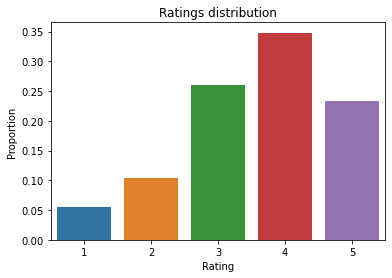

In [23]:
rating_distribution = pd.DataFrame({
    'Rating': list(Counter(all_ratings.rating).keys()),
    'Count': list(Counter(all_ratings.rating).values()),
    'Proportion': [Counter(all_ratings.rating)[x]/len(all_ratings) for x in Counter(all_ratings.rating).keys()]
})

rating_barplot = sns.barplot( x = "Rating", y = "Proportion", data = rating_distribution)
rating_barplot.set_title('Ratings distribution');

Neutral and positive ratings (3, 4, & 5)represents an 86% of the total. This tell us that people tend to rate more the movies they like, so in a sense **low ratings are more valuable**. 

Ratings are heavily centered around 3.6, but extreme values are more important from a business perspective. This could cause a loss of effectiveness for the models, it should be taken in consideration when choosing the **metrics** to compare the models performance.

##### Marginal distribution: Mean ratings by movie

Let's examine the relation between the **mean** of the ratings associated with each movie and its **deviations**.

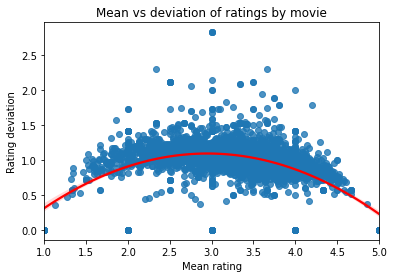

In [24]:
movies_ratings = list(map(lambda x: list(all_ratings.loc[all_ratings['movie'] == x]['rating']), all_ratings['movie'].unique()))

ratings_by_movie = pd.DataFrame({
    'Movie': all_ratings['movie'].unique(),
    'Mean rating': list(map(lambda ratings: sum(ratings)/len(ratings), movies_ratings)),
    'Rating deviation': list(map(lambda ratings: std_mod(ratings), movies_ratings)),
    'Rating count': list(map(lambda ratings: len(ratings), movies_ratings))
})

ratings_by_movie_regplot = sns.regplot(x="Mean rating", y="Rating deviation", data = ratings_by_movie, order = 2 , line_kws={"color": "red"})
ratings_by_movie_regplot.set_title('Mean vs deviation of ratings by movie');

There are some movies with **extreme** values of deviation in its ratings.

##### Marginal distribution: Mean ratings by user

Let's also examine the relation between the **mean** of the ratings associated with each user and its **deviations**.

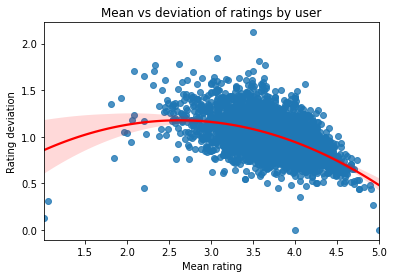

In [25]:
users_ratings = list(map(lambda x: list(all_ratings.loc[all_ratings['user'] == x]['rating']), all_ratings['user'].unique()))

ratings_by_user = pd.DataFrame({
    'User': all_ratings['user'].unique(),
    'Mean rating': list(map(lambda ratings: sum(ratings)/len(ratings), users_ratings)),
    'Rating deviation': list(map(lambda ratings: std_mod(ratings), users_ratings)),
    'Rating count': list(map(lambda ratings: len(ratings), users_ratings))
})

users_ids = list(all_ratings['user'].unique())

ratings_by_user_regplot = sns.regplot(x="Mean rating", y="Rating deviation", data = ratings_by_user, order = 2 , line_kws={"color": "red"})
ratings_by_user_regplot.set_title('Mean vs deviation of ratings by user');

There are some **infrequent extreme behaviours** among the users, such as: users who only give negative or positive feedback, (they have low and high mean rating but low deviations). 

These extreme user behaviours can be very harmful for modelling, we should treat them as **outliers**.

##### Marginal distribution: Acumulated ratings by user

Finally, let's check the **amount** of movies that users rate.

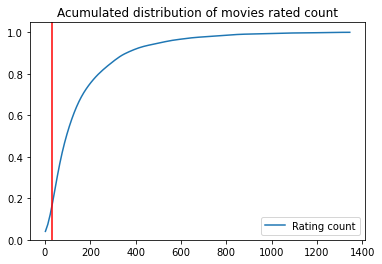

In [26]:
accumulated_ratings = sns.kdeplot(ratings_by_user["Rating count"], cumulative = True, cut=0)
accumulated_ratings.axvline(30, color = 'red')
accumulated_ratings.set_title('Acumulated distribution of movies rated count');

There are very few users that rate less than 20 movies.

## Conclusions

At last but not at least, let's look at the full picture to draw some preliminary conclusions:
- The dataset is extensive enough for our experiments.
- We have movies and users with and without ratings.
- All categories (genres, ages, and occupations) are properly represented.
- Most movies have scores that aggreed upon most users, with a deviation going from 0.5 to 1.25.
- Some movies have a very well defined score, and there are such movies for each possible score.
- Some movies have very conflicting scores.
- Users tends to be rate more the movies that they love than the ones that they hate.
- There exists some especial groups, such as "Haters" and "Lovers".

And save the results.

In [28]:
all_movies.to_csv(data_folder_path + 'movies_with_genre_and_year.csv', sep = ';')
all_users.to_csv(data_folder_path + 'users_with_age_interval_and_occupation.csv', sep = ';')

ratings_by_movie.to_csv(data_folder_path + 'ratings_by_movie_data.csv', sep = ';')
ratings_by_user.to_csv(data_folder_path + 'ratings_by_user_data.csv', sep = ';')

In general, looks like a representative sample of our production dataset and in acordance with what we would expect of our company users.

In [29]:
ratings_by_user

,User,Mean rating,Rating deviation,Rating count
0,2783,3.936170,1.050968,47
1,2784,3.266667,1.162919,15
2,2785,3.147239,0.610941,163
3,2786,4.094891,0.830337,137
4,2787,3.971014,1.017669,138
...,...,...,...,...
3250,6036,3.302928,1.023684,888
3251,6037,3.717822,0.877910,202
3252,6038,3.800000,1.105013,20
3253,6039,3.878049,0.730881,123
